## Theta Absolute Power Topography

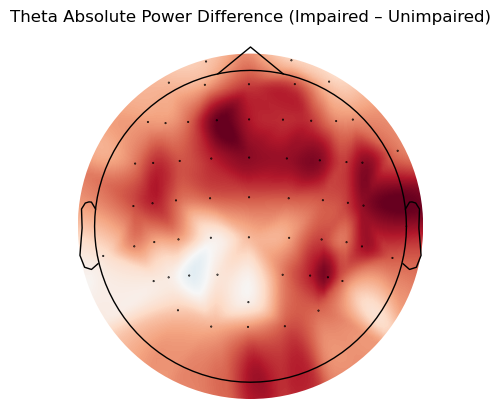

In [4]:
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
META_PATH = "participants.csv"

meta = pd.read_csv(META_PATH)
pd_subs = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

# Storage: channel -> list of theta values for each group
theta_imp = {}
theta_unimp = {}

for subj in pd_subs:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        continue

    df = pd.read_csv(csv_file)
    df['channel'] = df['channel'].str.strip().str.upper()

    moca = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca) == 0 or np.isnan(moca[0]):
        continue

    label = int(moca[0] < 26)  # 1 = impaired

    for _, row in df.iterrows():
        ch = row['channel']
        val = row['theta_abs']

        if label == 1:
            theta_imp.setdefault(ch, []).append(val)
        else:
            theta_unimp.setdefault(ch, []).append(val)

# Keep only channels present in both groups
common_ch = sorted(set(theta_imp.keys()).intersection(theta_unimp.keys()))

imp_mean = np.array([np.mean(theta_imp[ch]) for ch in common_ch])
unimp_mean = np.array([np.mean(theta_unimp[ch]) for ch in common_ch])

diff = imp_mean - unimp_mean   # impaired – unimpaired

# ---- Build MNE object for topomap ----
info = mne.create_info(common_ch, sfreq=250, ch_types="eeg")
montage = mne.channels.make_standard_montage("standard_1020")
# --- Fix channel name capitalization (AFZ -> AFz, CPZ -> CPz, etc.)
def fix_channel_name(ch):
    ch = ch.strip()
    if ch.upper() == "FP1": return "Fp1"
    if ch.upper() == "FP2": return "Fp2"
    if ch.endswith("Z"): return ch[:-1] + "z"
    return ch

fixed_ch = [fix_channel_name(ch) for ch in common_ch]

info = mne.create_info(fixed_ch, sfreq=250, ch_types="eeg")
montage = mne.channels.make_standard_montage("standard_1020")
info.set_montage(montage)


info.set_montage(montage)

# ---- Plot ----
fig, ax = plt.subplots()
mne.viz.plot_topomap(diff, info, contours=0, axes=ax, show=False)
ax.set_title("Theta Absolute Power Difference (Impaired – Unimpaired)")
plt.show()


## Temporal Correlation Heatmaps

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_temporal_corr_matrix(pli_windows, subj, band):
    n_win = pli_windows.shape[0]
    corr_mat = np.zeros((n_win, n_win))

    for i in range(n_win):
        for j in range(n_win):
            v1 = pli_windows[i].flatten()
            v2 = pli_windows[j].flatten()
            if np.std(v1) == 0 or np.std(v2) == 0:
                corr_mat[i, j] = np.nan
            else:
                corr_mat[i, j] = np.corrcoef(v1, v2)[0, 1]

    plt.imshow(corr_mat, vmin=0, vmax=1)
    plt.colorbar(label="PLI similarity")
    plt.title(f"{subj} {band.upper()} – Temporal Network Stability")
    plt.xlabel("Window")
    plt.ylabel("Window")
    plt.show()


In [ ]:
def plot_temporal_corr_trace(pli_windows, subj, band):
    corrs = []
    for i in range(len(pli_windows) - 1):
        v1 = pli_windows[i].flatten()
        v2 = pli_windows[i + 1].flatten()
        if np.std(v1) == 0 or np.std(v2) == 0:
            corrs.append(np.nan)
        else:
            corrs.append(np.corrcoef(v1, v2)[0, 1])

    plt.plot(corrs)
    plt.ylim(0, 1)
    plt.xlabel("Window index")
    plt.ylabel("Correlation with next window")
    plt.title(f"{subj} {band.upper()} – Consecutive PLI Stability")
    plt.show()
